# BPI Challenge 2019

https://icpmconference.org/2019/icpm-2019/contests-challenges/bpi-challenge-2019/

In [1]:
import pandas as pd
import pm4py
import numpy as np

In [2]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery



# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [43]:
# Cargamos dos dataset
log = pm4py.read_xes('BPI_Challenge_2019.xes')

parsing log, completed traces ::   0%|          | 0/251734 [00:00<?, ?it/s]

In [44]:
log.head()

User org:resource                         concept:name  \
0  batch_00     batch_00                         SRM: Created   
1  batch_00     batch_00                        SRM: Complete   
2  batch_00     batch_00               SRM: Awaiting Approval   
3  batch_00     batch_00              SRM: Document Completed   
4  batch_00     batch_00  SRM: In Transfer to Execution Syst.   

   Cumulative net worth (EUR)            time:timestamp case:Spend area text  \
0                       298.0 2018-01-02 12:53:00+00:00         CAPEX & SOCS   
1                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   
2                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   
3                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   
4                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   

     case:Company case:Document Type case:Sub spend area text  \
0  companyID_0000  EC Purchase order      Facility Management   
1  companyID_0000  EC Purchase order      Facility Management   
2  companyID_0000  EC Purchase order      Facility Management   
3  companyID_0000  EC Purchase order      Facility Management   
4  companyID_0000  EC Purchase order      Facility Management   

  case:Purchasing Document  ...    case:Vendor case:Item Type  \
0               2000000000  ...  vendorID_0000       Standard   
1               2000000000  ...  vendorID_0000       Standard   
2               2000000000  ...  vendorID_0000       Standard   
3               2000000000  ...  vendorID_0000       Standard   
4               2000000000  ...  vendorID_0000       Standard   

               case:Item Category case:Spend classification text  \
0  3-way match, invoice before GR                            NPR   
1  3-way match, invoice before GR                            NPR   
2  3-way match, invoice before GR                            NPR   
3  3-way match, invoice before GR                            NPR   
4  3-way match, invoice before GR                            NPR   

           case:Source    case:Name case:GR-Based Inv. Verif.  case:Item  \
0  sourceSystemID_0000  vendor_0000                     False      00001   
1  sourceSystemID_0000  vendor_0000                     False      00001   
2  sourceSystemID_0000  vendor_0000                     False      00001   
3  sourceSystemID_0000  vendor_0000                     False      00001   
4  sourceSystemID_0000  vendor_0000                     False      00001   

  case:concept:name case:Goods Receipt  
0  2000000000_00001               True  
1  2000000000_00001               True  
2  2000000000_00001               True  
3  2000000000_00001               True  
4  2000000000_00001               True  

[5 rows x 21 columns]

In [45]:
log.shape

(1595923, 21)

In [46]:
log.columns

Index(['User', 'org:resource', 'concept:name', 'Cumulative net worth (EUR)',
       'time:timestamp', 'case:Spend area text', 'case:Company',
       'case:Document Type', 'case:Sub spend area text',
       'case:Purchasing Document', 'case:Purch. Doc. Category name',
       'case:Vendor', 'case:Item Type', 'case:Item Category',
       'case:Spend classification text', 'case:Source', 'case:Name',
       'case:GR-Based Inv. Verif.', 'case:Item', 'case:concept:name',
       'case:Goods Receipt'],
      dtype='object')

In [47]:
# actividades que comienzan y que acaban

starts = pm4py.stats.get_start_activities(log)
ends = pm4py.stats.get_end_activities(log)

In [48]:
# Actividades de inicio A_SUBMITED comienza 13.087 veces
starts

{'Create Purchase Order Item': 199867,
 'Create Purchase Requisition Item': 46526,
 'Vendor creates invoice': 3457,
 'SRM: Created': 1360,
 'Change Approval for Purchase Order': 378,
 'Vendor creates debit memo': 122,
 'Release Purchase Order': 22,
 'Change Currency': 2}

In [49]:
# Actividades que acaban: 11 y sus repeticiones.
ends

{'Clear Invoice': 181328,
 'Record Invoice Receipt': 23091,
 'Record Goods Receipt': 22776,
 'Delete Purchase Order Item': 8123,
 'Remove Payment Block': 5397,
 'Create Purchase Order Item': 4447,
 'Cancel Invoice Receipt': 1348,
 'Change Approval for Purchase Order': 1346,
 'Record Service Entry Sheet': 921,
 'Change Delivery Indicator': 718,
 'Change Price': 529,
 'Change Quantity': 525,
 'Cancel Goods Receipt': 440,
 'Receive Order Confirmation': 232,
 'Block Purchase Order Item': 167,
 'Vendor creates invoice': 68,
 'Set Payment Block': 61,
 'SRM: Change was Transmitted': 47,
 'SRM: Transfer Failed (E.Sys.)': 44,
 'SRM: In Transfer to Execution Syst.': 30,
 'Cancel Subsequent Invoice': 24,
 'Change Storage Location': 20,
 'Reactivate Purchase Order Item': 14,
 'Record Subsequent Invoice': 9,
 'SRM: Deleted': 9,
 'SRM: Transaction Completed': 6,
 'Vendor creates debit memo': 5,
 'Change Final Invoice Indicator': 3,
 'Update Order Confirmation': 3,
 'Change Currency': 1,
 'Release Pu

In [50]:
# guardamos lasa variantes
variantes = pm4py.get_variants_as_tuples(log)

In [51]:
# Cuántas variantes y cuántos registros?
print('Num variantes: ',len(variantes),' y en num casos: ', len(log['case:concept:name'].unique()))

Num variantes:  11973  y en num casos:  251734


In [53]:
# Variantes, orden por número que se repiten.
# Las primeras 2 variantes, suman unos 80000 casos de los 250000
# La 15a variante, menos del 2% del total (1% = 2500)
variantes_df = pd.DataFrame(sorted(variantes.items(), key=lambda x: x[1], reverse=True)[:15], columns = ['variantes', 'repeticiones'])
variantes_df

variantes  repeticiones
0   (Create Purchase Order Item, Vendor creates in...         50286
1   (Create Purchase Order Item, Record Goods Rece...         30798
2   (Create Purchase Order Item, Record Goods Rece...         12214
3   (Create Purchase Order Item, Vendor creates in...         11383
4   (Create Purchase Order Item, Receive Order Con...          9694
5   (Create Purchase Requisition Item, Create Purc...          8921
6   (Create Purchase Order Item, Vendor creates in...          8835
7   (Create Purchase Order Item, Record Goods Rece...          7985
8   (Create Purchase Order Item, Delete Purchase O...          5298
9   (Create Purchase Order Item, Receive Order Con...          4244
10  (Create Purchase Requisition Item, Create Purc...          4210
11  (Create Purchase Requisition Item, Create Purc...          3723
12  (Create Purchase Order Item, Record Goods Rece...          3548
13                      (Create Purchase Order Item,)          2835
14  (Create Purchase Order Item, Vendor creates in...          2765

In [54]:
# Número de casos que representan las 15 variantes más repetidas:
variantes_df['repeticiones'].sum()

166739

In [56]:
# Ahora seleccionamos los registros (filtramos la dataset) pero de otra manera
# Compruebo que el num de casos, es efectivamente, el mismo
len(pm4py.filter_variants_top_k(log, 15)['case:concept:name'].unique())

166739

In [57]:
top = 15 # El top de variantes por repeticiones
variantes_15 = pm4py.filter_variants_top_k(log, top)
variantes_15.head() #Acabamos de filtrar la dataset.


User org:resource                concept:name  \
7477  batch_03     batch_03  Create Purchase Order Item   
7478  user_029     user_029  Receive Order Confirmation   
7479  user_030     user_030        Record Goods Receipt   
7480      NONE         NONE      Vendor creates invoice   
7481  user_004     user_004      Record Invoice Receipt   

      Cumulative net worth (EUR)            time:timestamp  \
7477                       867.0 2018-01-02 02:43:00+00:00   
7478                       867.0 2018-01-02 08:45:00+00:00   
7479                       867.0 2018-01-03 10:31:00+00:00   
7480                       867.0 2018-01-03 22:59:00+00:00   
7481                       867.0 2018-01-04 15:34:00+00:00   

     case:Spend area text    case:Company case:Document Type  \
7477            Packaging  companyID_0000        Standard PO   
7478            Packaging  companyID_0000        Standard PO   
7479            Packaging  companyID_0000        Standard PO   
7480            Packaging  companyID_0000        Standard PO   
7481            Packaging  companyID_0000        Standard PO   

             case:Sub spend area text case:Purchasing Document  ...  \
7477  Plastic Containers & Lids < 30L               4507000223  ...   
7478  Plastic Containers & Lids < 30L               4507000223  ...   
7479  Plastic Containers & Lids < 30L               4507000223  ...   
7480  Plastic Containers & Lids < 30L               4507000223  ...   
7481  Plastic Containers & Lids < 30L               4507000223  ...   

        case:Vendor case:Item Type              case:Item Category  \
7477  vendorID_0104       Standard  3-way match, invoice before GR   
7478  vendorID_0104       Standard  3-way match, invoice before GR   
7479  vendorID_0104       Standard  3-way match, invoice before GR   
7480  vendorID_0104       Standard  3-way match, invoice before GR   
7481  vendorID_0104       Standard  3-way match, invoice before GR   

     case:Spend classification text          case:Source    case:Name  \
7477                             PR  sourceSystemID_0000  vendor_0104   
7478                             PR  sourceSystemID_0000  vendor_0104   
7479                             PR  sourceSystemID_0000  vendor_0104   
7480                             PR  sourceSystemID_0000  vendor_0104   
7481                             PR  sourceSystemID_0000  vendor_0104   

     case:GR-Based Inv. Verif.  case:Item case:concept:name case:Goods Receipt  
7477                     False      00010  4507000223_00010               True  
7478                     False      00010  4507000223_00010               True  
7479                     False      00010  4507000223_00010               True  
7480                     False      00010  4507000223_00010               True  
7481                     False      00010  4507000223_00010               True  

[5 rows x 21 columns]


(process:19228): GLib-GIO-WARNING **: 21:26:26.674: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.5.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs



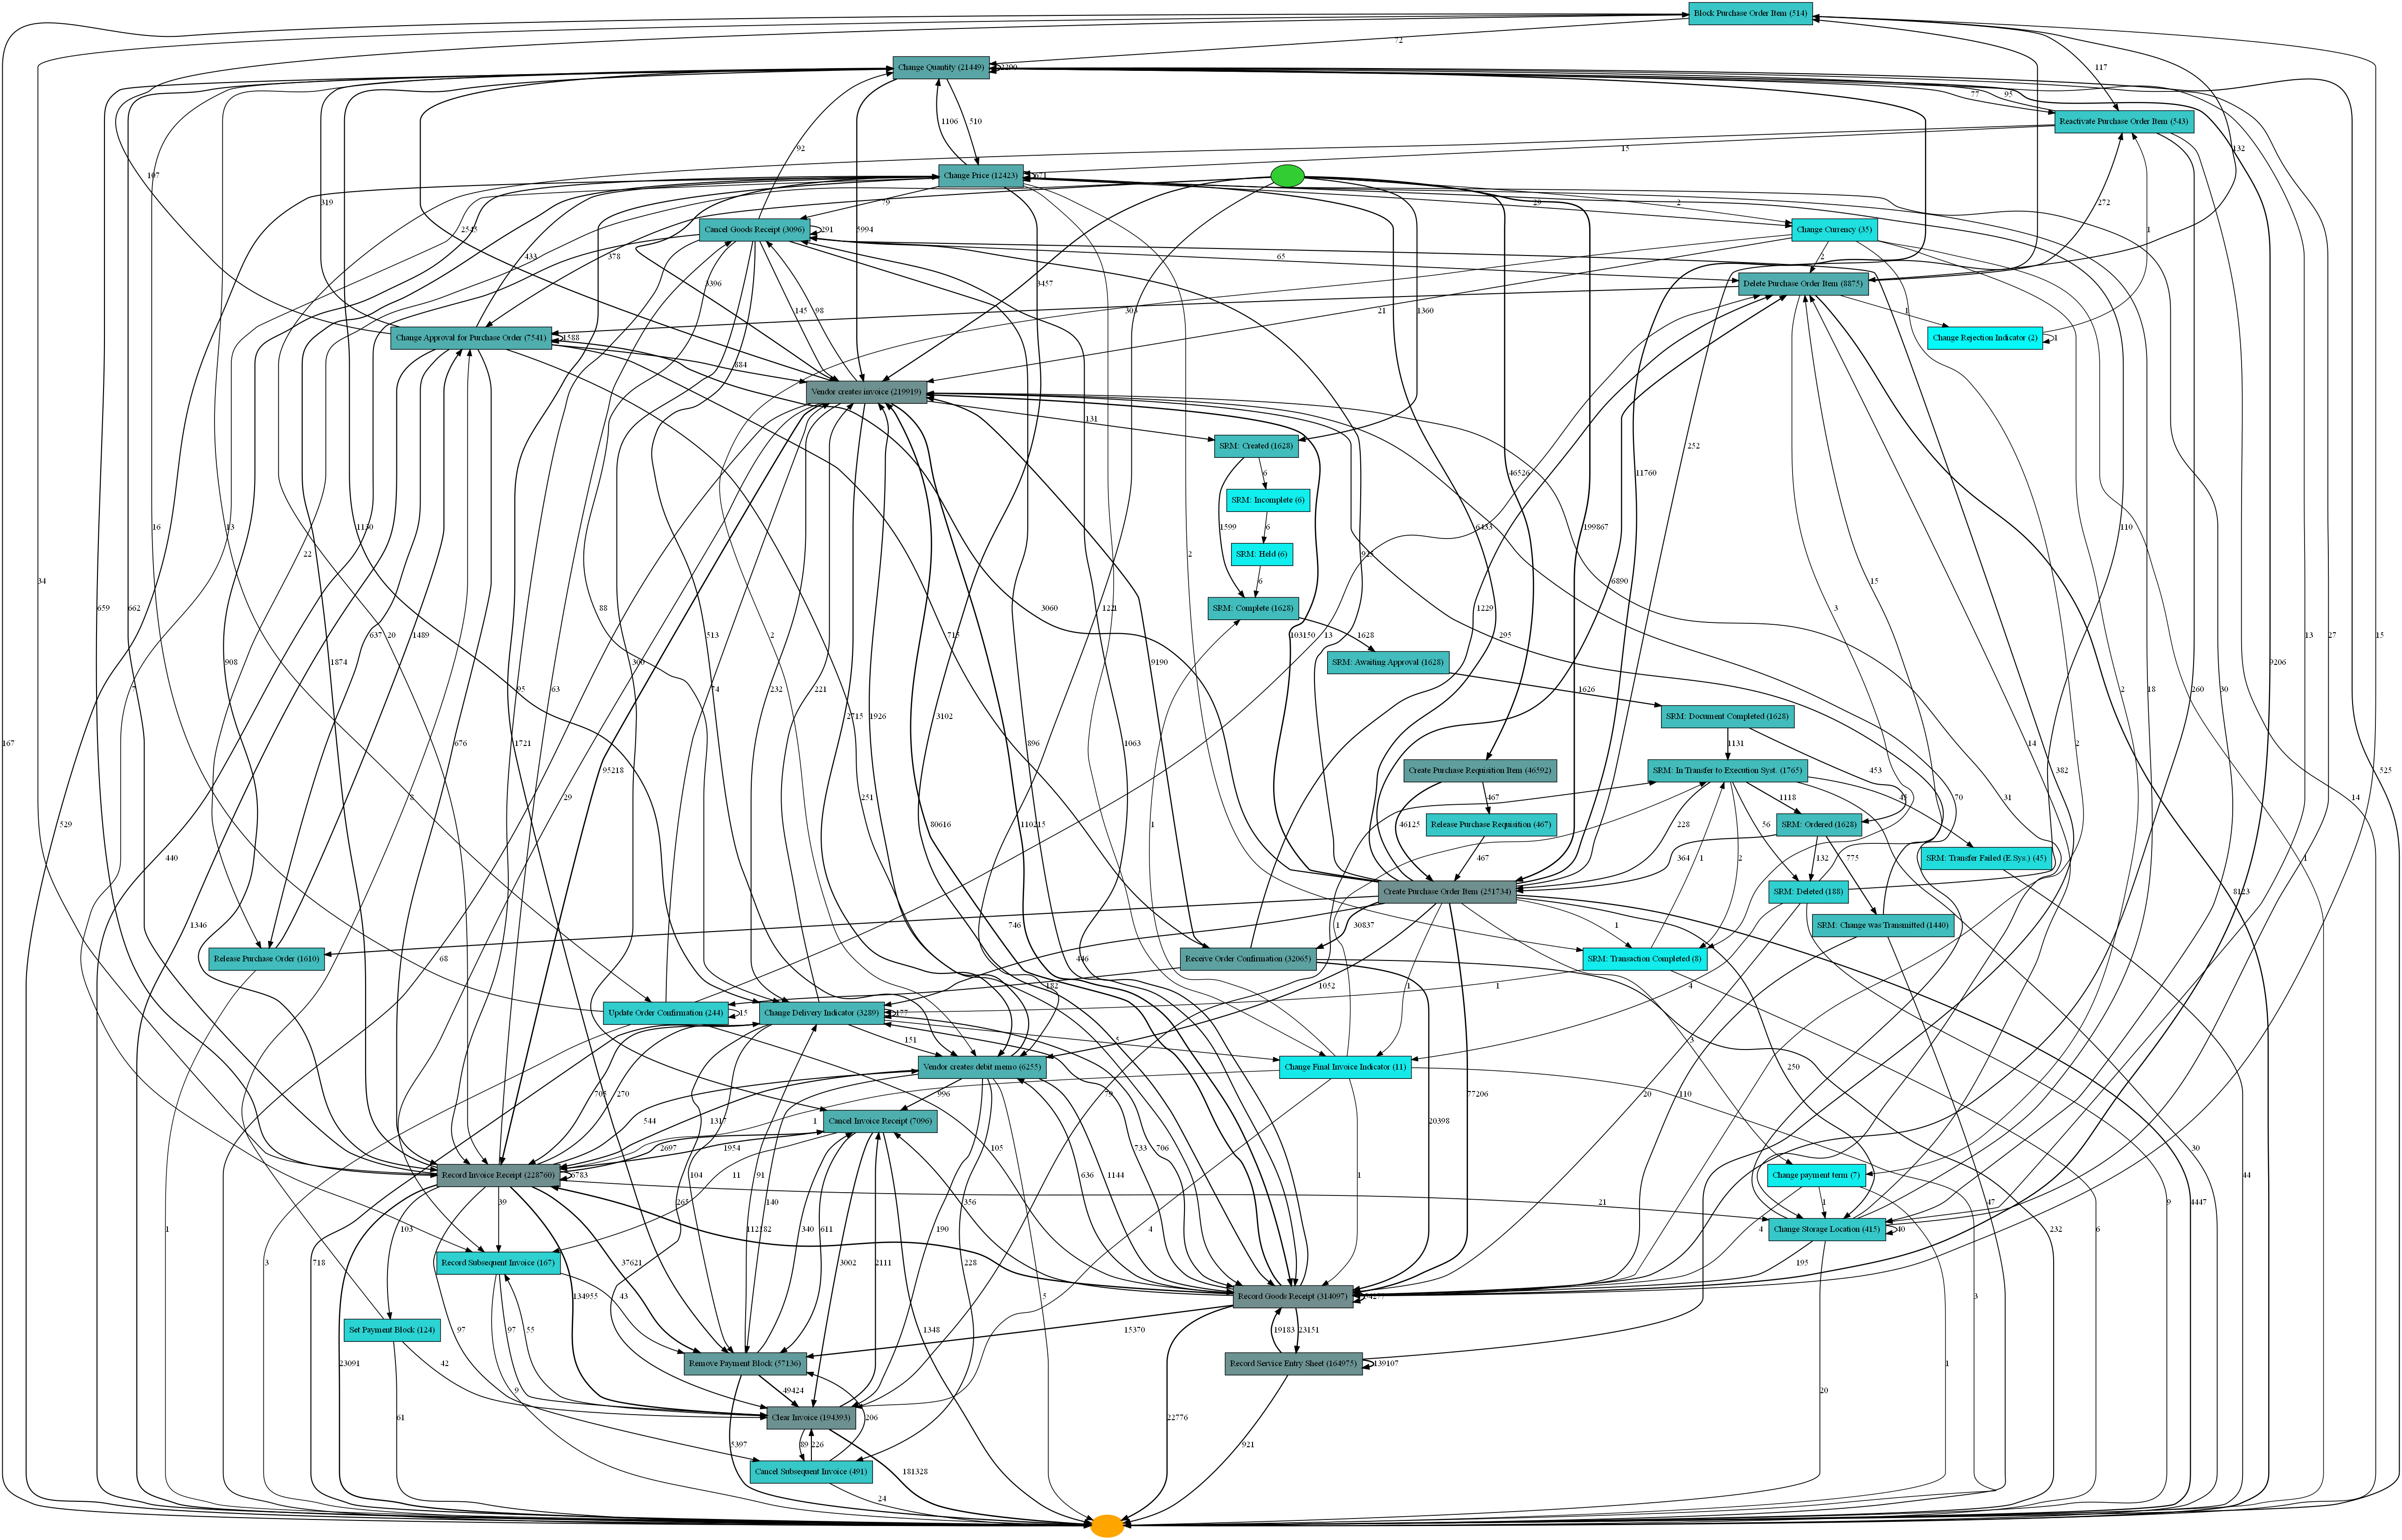

In [58]:
# Grafo dirigido de todos los eventos y variantes
map = pm4py.discover_heuristics_net(log)
pm4py.view_heuristics_net(map)

C:\Users\marco\anaconda3\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
C:\Users\marco\anaconda3\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


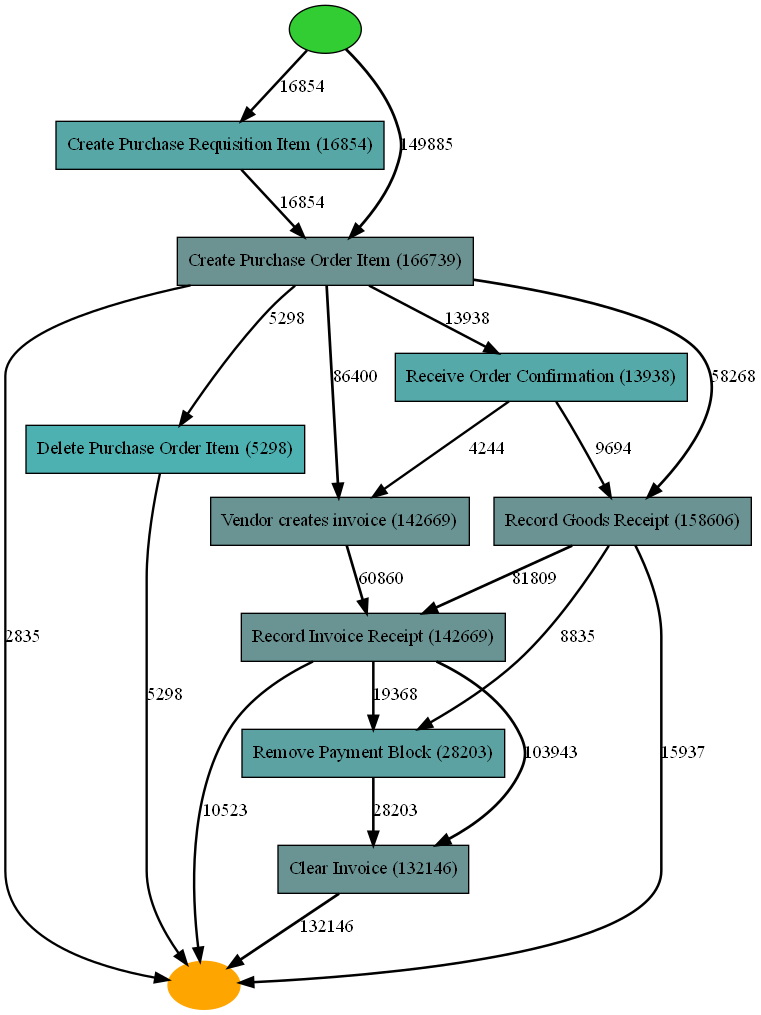

In [59]:
# Grafo dirigido sólo con las 10 variantes más comunes
map = pm4py.discover_heuristics_net(variantes_15)
pm4py.view_heuristics_net(map)

C:\Users\marco\anaconda3\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
C:\Users\marco\anaconda3\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


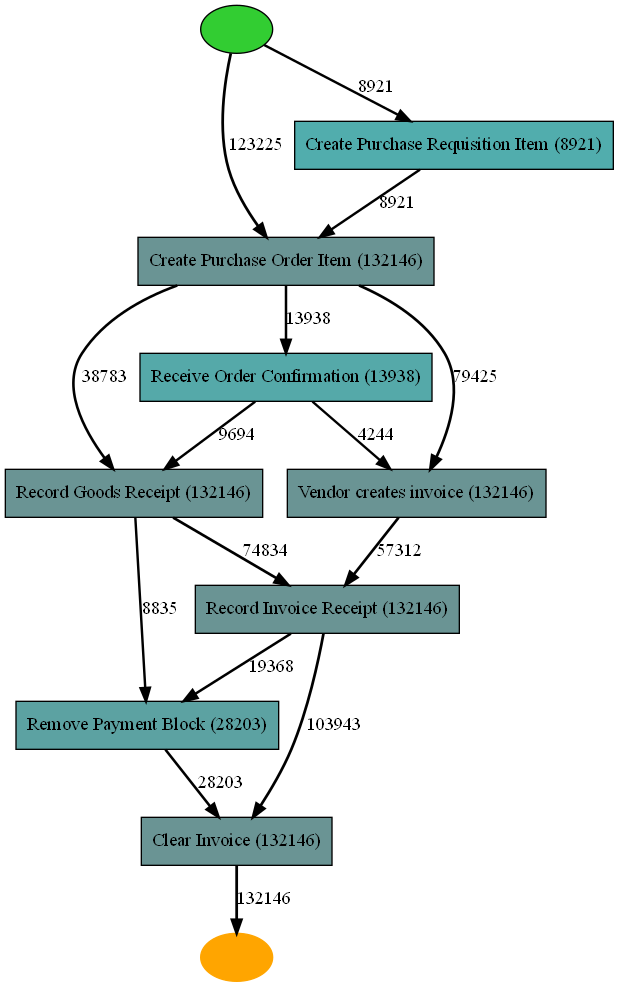

In [60]:
# Filtramos esta vez sólo por eventos que acaben de una determinada manera

completed = pm4py.filter_end_activities(variantes_15, ["Clear Invoice"])
# Grafo dirigido sólo las que acaban con éxito
map = pm4py.discover_heuristics_net(completed)
pm4py.view_heuristics_net(map)

In [62]:
# hay 1,5 M registros.
# Hay 250 M casos (casa caso con x actividades)
# Hay unas 12000 variantes
for c in log.columns:
    print(c, ' ', len(log[c].unique()))

User   628
org:resource   628
concept:name   42
Cumulative net worth (EUR)   25221
time:timestamp   167432
case:Spend area text   21
case:Company   4
case:Document Type   3
case:Sub spend area text   136
case:Purchasing Document   76349
case:Purch. Doc. Category name   1
case:Vendor   1975
case:Item Type   6
case:Item Category   4
case:Spend classification text   4
case:Source   1
case:Name   1899
case:GR-Based Inv. Verif.   2
case:Item   490
case:concept:name   251734
case:Goods Receipt   2
start_timestamp   167432


In [69]:
# Por cada caso:
for c in log.columns:
    print(c, ' ', len(log[log['case:concept:name'] == '2000000000_00001'][c].unique()))


User   5
org:resource   5
concept:name   12
Cumulative net worth (EUR)   1
time:timestamp   6
case:Spend area text   1
case:Company   1
case:Document Type   1
case:Sub spend area text   1
case:Purchasing Document   1
case:Purch. Doc. Category name   1
case:Vendor   1
case:Item Type   1
case:Item Category   1
case:Spend classification text   1
case:Source   1
case:Name   1
case:GR-Based Inv. Verif.   1
case:Item   1
case:concept:name   1
case:Goods Receipt   1
start_timestamp   6


In [74]:
log[log['case:concept:name'] == '2000000000_00001'].iloc[1,:]

User                                                    batch_00
org:resource                                            batch_00
concept:name                                       SRM: Complete
Cumulative net worth (EUR)                                 298.0
time:timestamp                         2018-01-02 13:53:00+00:00
case:Spend area text                                CAPEX & SOCS
case:Company                                      companyID_0000
case:Document Type                             EC Purchase order
case:Sub spend area text                     Facility Management
case:Purchasing Document                              2000000000
case:Purch. Doc. Category name                    Purchase order
case:Vendor                                        vendorID_0000
case:Item Type                                          Standard
case:Item Category                3-way match, invoice before GR
case:Spend classification text                               NPR
case:Source              

In [83]:
pm4py.stats.get_case_duration(log, log['case:concept:name'][15])

32753340.0

In [123]:
# Seleccionamos la dataset, sus variables.
colum = ['case:concept:name', 'case:Goods Receipt',
 'Cumulative net worth (EUR)',
 'case:Item',
        'case:Spend area text', 'case:Company',
       'case:Document Type', 'case:Sub spend area text',
       'case:Purchasing Document', 'case:Purch. Doc. Category name',
       'case:Vendor', 'case:Item Type', 'case:Item Category',
       'case:Spend classification text', 'case:Source', 'case:Name',
       'case:GR-Based Inv. Verif.'
       ]

In [125]:
variables = ['case_name',
            'GoodsReceipt',
             'worth',
             'case_item',
             'SpendAreaText',
             'Company',
             'Document_type',
             'SubSpendAreaText',
             'PurchasingDocument',
             'CategoryDocument',
             'Vendor',
             'ItemType',
             'ItemCategory',
             'SpendClassText',
             'Source',
             'case_Name',
             'Verification']

In [141]:
casos = variantes_15['case:concept:name'].unique()

In [142]:
len(casos)

166739

In [187]:
# Función que devuelve una df con primary key = case
case_df(df):
    prueba = df.groupby(['case:concept:name', 'case:Goods Receipt',
         'Cumulative net worth (EUR)',
         'case:Item',
        'case:Spend area text', 'case:Company',
       'case:Document Type', 'case:Sub spend area text',
       'case:Purchasing Document', 'case:Purch. Doc. Category name',
       'case:Vendor', 'case:Item Type', 'case:Item Category',
       'case:Spend classification text', 'case:Source', 'case:Name',
       'case:GR-Based Inv. Verif.']).count().reset_index()
    prueba = prueba.iloc[:,:-5]
    prueba.columns = variables
    return prueba

In [183]:
# Asociar las variantes a casos.
# Pasos, enumerar las variantes
eventos = []
for i in range(15):
    eventos.append('evento '+str(i))    

In [184]:
variantes_df['evento'] = eventos

In [185]:
variantes_df.head()

variantes  repeticiones    evento
0  (Create Purchase Order Item, Vendor creates in...         50286  evento 0
1  (Create Purchase Order Item, Record Goods Rece...         30798  evento 1
2  (Create Purchase Order Item, Record Goods Rece...         12214  evento 2
3  (Create Purchase Order Item, Vendor creates in...         11383  evento 3
4  (Create Purchase Order Item, Receive Order Con...          9694  evento 4

In [196]:
data = pm4py.filtering.filter_variants(variantes_15, [variantes_df.variantes[0]])
data = case_df(data)

In [198]:
data['evento'] = variantes_df.evento[0]

In [202]:
# Asociamos cada caso a cada variante (nombre)
dataframes = []
for i in range(15):
    data = pm4py.filtering.filter_variants(variantes_15, [variantes_df.variantes[i]])
    data = case_df(data)
    data['evento'] = variantes_df.evento[i]
    if i == 0:
        dataframes = data
    else:
        dataframes = pd.concat([dataframes, data], ignore_index = True)

In [204]:
dataframes.columns

Index(['case_name', 'GoodsReceipt', 'worth', 'case_item', 'SpendAreaText',
       'Company', 'Document_type', 'SubSpendAreaText', 'PurchasingDocument',
       'CategoryDocument', 'Vendor', 'ItemType', 'ItemCategory',
       'SpendClassText', 'Source', 'case_Name', 'Verification', 'evento'],
      dtype='object')

In [205]:
dataframes.shape

(166841, 18)

In [208]:
variantes_df.variantes[0][-1]

'Clear Invoice'

In [209]:
# Genero la columna en la dataset de variantes de la actividad final
ends = []
for i in range(15):
    ends.append(variantes_df.variantes[i][-1])

In [211]:
variantes_df['ends'] = ends

In [224]:
# Ahora relaciono el caso, con su caso final
endlist=[]
for i in range(dataframes.shape[0]):
    endlist.append(variantes_df.ends[list(variantes_df.evento).index(dataframes.evento[i])])

In [225]:
dataframes['end'] = endlist

In [240]:
dataframes.dtypes

case_name              object
GoodsReceipt             bool
worth                 float64
case_item              object
SpendAreaText          object
Company                object
Document_type          object
SubSpendAreaText       object
PurchasingDocument     object
CategoryDocument       object
Vendor                 object
ItemType               object
ItemCategory           object
SpendClassText         object
Source                 object
case_Name              object
Verification             bool
evento                 object
end                    object
dtype: object

In [228]:
dataframes.head()

case_name  GoodsReceipt    worth case_item     SpendAreaText  \
0  4507000227_00010          True  43301.0     00010  Specialty Resins   
1  4507000228_00010          True    110.0     00010             Sales   
2  4507000228_00030          True    617.0     00030             Sales   
3  4507000228_00040          True     75.0     00040             Sales   
4  4507000234_00010          True    239.0     00010             Sales   

          Company Document_type     SubSpendAreaText PurchasingDocument  \
0  companyID_0000   Standard PO         Alkyd Resins         4507000227   
1  companyID_0000   Standard PO  Products for Resale         4507000228   
2  companyID_0000   Standard PO  Products for Resale         4507000228   
3  companyID_0000   Standard PO  Products for Resale         4507000228   
4  companyID_0000   Standard PO  Products for Resale         4507000234   

  CategoryDocument         Vendor  ItemType                    ItemCategory  \
0   Purchase order  vendorID_0107  Standard   3-way match, invoice after GR   
1   Purchase order  vendorID_0108  Standard  3-way match, invoice before GR   
2   Purchase order  vendorID_0108  Standard  3-way match, invoice before GR   
3   Purchase order  vendorID_0108  Standard  3-way match, invoice before GR   
4   Purchase order  vendorID_0114  Standard  3-way match, invoice before GR   

  SpendClassText               Source    case_Name  Verification    evento  \
0             PR  sourceSystemID_0000  vendor_0107          True  evento 0   
1            NPR  sourceSystemID_0000  vendor_0108         False  evento 0   
2            NPR  sourceSystemID_0000  vendor_0108         False  evento 0   
3            NPR  sourceSystemID_0000  vendor_0108         False  evento 0   
4            NPR  sourceSystemID_0000  vendor_0114         False  evento 0   

             end  
0  Clear Invoice  
1  Clear Invoice  
2  Clear Invoice  
3  Clear Invoice  
4  Clear Invoice

In [233]:
X = dataframes.iloc[:,:-1]
y = dataframes.iloc[:,-1] # labels = last activity

In [267]:
# evento lo quitamos, duplicidad vs end
X = X.drop(columns = ['evento'])

In [243]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [244]:
labelencoder = LabelEncoder()

In [268]:
Xc = X.select_dtypes(include='object') # Seleccionamos las columnas categóricas

In [269]:
for c in Xc.columns:
    X[c] = labelencoder.fit_transform(Xc[c])

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [271]:
clf = RandomForestClassifier(n_estimators = 100, max_depth=4, random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [272]:
y_pred = clf.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.88815899882525

<BarContainer object of 17 artists>

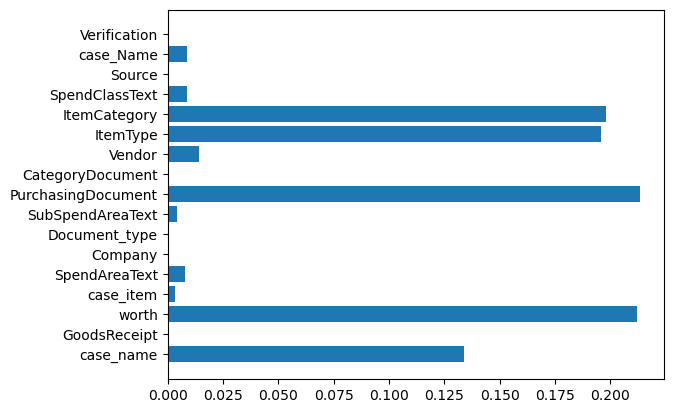

In [273]:
from matplotlib import pyplot as plt
plt.barh(X.columns, clf.feature_importances_)